# i. Perkenalan

Name    : Ibrahim Hasan

Batch   : FTDS 009

> Dataset

Dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/jehanbhathena/tire-texture-image-recognition) that is consisting of total 1028 images of tire texture for training/testing. The dataset was divided into two class, one for normal tire and one for cracked tire.

Mainly the resolution of the images for train/test is 72x72, and it has a various size of images at the range of 220x220 to 1200x1200. 


> Objective

The Objective is to create an `Image Classifications` model and deployed to the some sort of web application that can predict whether the tire is normal or cracked, which classify.

Maybe i can act as a automotive workshop which have the web application and customer are able to capture and upload their tire before they have a `mudik` journey.

Car is the most vehicle being used for mudik travel, which carry around 21,3 Mio people based on ministry of transportation data.

Tire condition is one pf the most important factor in the car's safety, as one of highest factor behind accidents is related to the tire condition. 

Let say once the image uploaded and customer acquired the result from model's prediction, they can consider the model's result whether it is showing normal or cracked. If the result is normal, they can consider the tire is good to go for the journey, and if the result is cracked, they can consider to change the tire before the travel so they can feel safety along the holiday time.


# ii. Import Libraries

In [96]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# iii. Data Loading

> assign the path of the dataset

In [3]:
main_path = '/Users/ibrahimhasan/Documents/ftds009/Milestone/p2---ftds009---m2-ibhas-13/Tire Textures'

> assign the path of train and test dataset which already been separated from the original dataset.

In [4]:
train_dir = os.path.join(main_path, 'training_data')
test_dir = os.path.join(main_path, 'testing_data')

# iv. Exploratory Data Analysis (EDA)

Observation distribution of each labels in train set, and we can consider that the class between in two classes is quite balanced.

In [28]:
print('train set: \n' + '='*50)
num_crack= len(os.listdir(os.path.join(train_dir, 'cracked')))
num_normal= len(os.listdir(os.path.join(train_dir, 'normal')))
print(f'cracked = {num_crack}', 'images')
print(f'normal = {num_normal}', 'images')

train set: 
cracked = 327 images
normal = 376 images


Observation distribution for each labels in test set, and it showing that the class between in two classes is imbalanced as we have more `cracked` class is three times than normal class.

In [29]:
print('test set: \n' + '='*50)
num_cracked = len(os.listdir(os.path.join(test_dir, 'cracked')))
num_normal = len(os.listdir(os.path.join(test_dir, 'normal')))
print(f'cracked = {num_crack}', 'images')
print(f'normal = {num_normal}', 'images')

test set: 
cracked = 327 images
normal = 115 images


assigning the path of the train and test dataset separating both classes for further data processing.

In [6]:
train_normal = glob.glob(train_dir+"/normal/*.jpg")
train_crack = glob.glob(train_dir+"/cracked/*.jpg")

test_normal = glob.glob(test_dir+"/normal/*.jpg")
test_crack = glob.glob(test_dir+"/cracked/*.jpg")

Create function in order to create dataframe for train and test dataset

In [13]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_normal + train_crack)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_normal + test_crack)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

/content/images/Tire Textures/testing_data/cracked/Cracked-1.jpg

Create train and test Dataframe for later processing.

In [8]:
print(train_df.shape)
train_df.head()

(703, 2)


,images,label
0,/Users/ibrahimhasan/Documents/ftds009/Mileston...,cracked
1,/Users/ibrahimhasan/Documents/ftds009/Mileston...,cracked
2,/Users/ibrahimhasan/Documents/ftds009/Mileston...,normal
3,/Users/ibrahimhasan/Documents/ftds009/Mileston...,normal
4,/Users/ibrahimhasan/Documents/ftds009/Mileston...,normal


In [9]:
print(test_df.shape)
test_df.head()

(325, 2)


,images,label
0,/Users/ibrahimhasan/Documents/ftds009/Mileston...,cracked
1,/Users/ibrahimhasan/Documents/ftds009/Mileston...,cracked
2,/Users/ibrahimhasan/Documents/ftds009/Mileston...,cracked
3,/Users/ibrahimhasan/Documents/ftds009/Mileston...,cracked
4,/Users/ibrahimhasan/Documents/ftds009/Mileston...,cracked


Preview several images from the dataset for both classes.

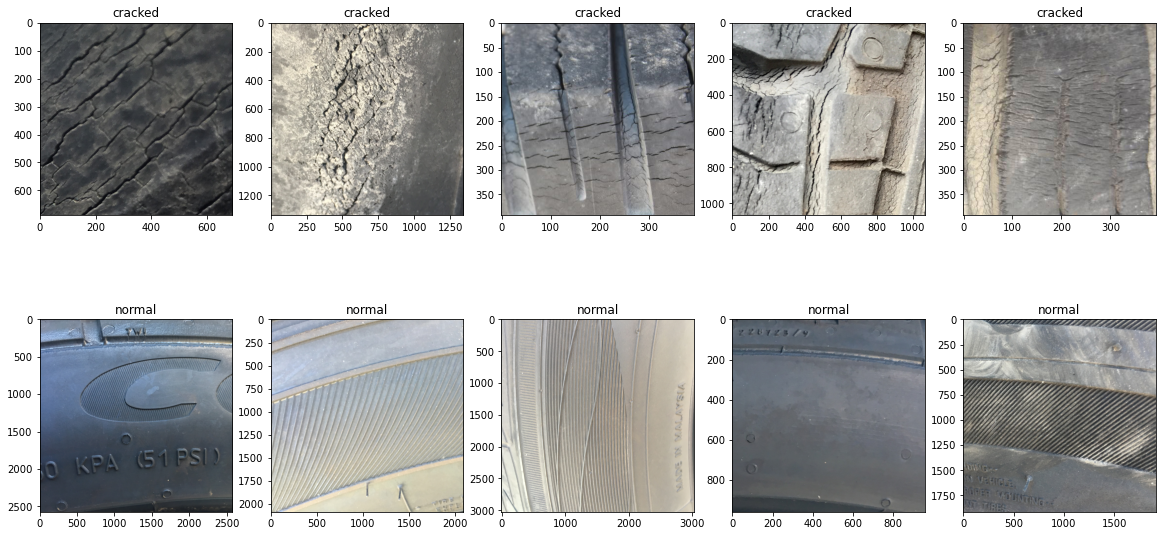

In [15]:
# Get few samples for both the classes
crack_samples = (train_df[train_df['label']=="cracked"]['images'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']=='normal']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(crack_samples + normal_samples)

# v. Data Preprocessing

> Split the data into train and val set

In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, stratify = train_df['label'])
print(train_df.shape)
print(val_df.shape)

(562, 2)
(141, 2)


> Comparison both classes in train set after splitting train/val test.

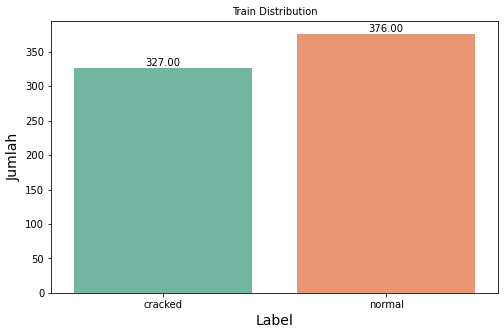

In [33]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

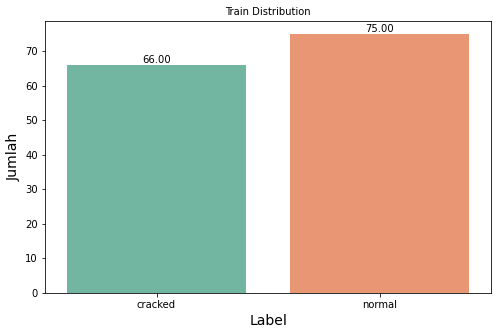

In [34]:
visualize_data(val_df, 'Train')

After splitting train/val set, here are above the dataset that will be used for training and validation.
train set = 376 images of normal tire, and 327 images of cracked tire.
val set = 75 images of normal tire, and 66 images of cracked tire.

> set the size of the image for training purpose.

In [36]:
img_height= 224
img_width= 224
SEED = 1
BATCH = 128

> Create preprocessing pipeline with ImageDatagenerator, and adding the common parameter for rescaling, rotation, etc for preprocessing train set.

In [44]:
# pipeline preprocessing
# create image generator

train_datagen_pipe = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

> Create train/val/test set from DataFrame which previosly created and adding other parameter for training related purpose such resizing images to the same size, assign batch size, shuffle, seed, etc.

In [45]:
ds_train_pipe = train_datagen_pipe.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

ds_val_pipe = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test_pipe = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED)

Found 703 validated image filenames belonging to 2 classes.
Found 141 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.


> Checking classes and showing class 0 is belongs to cracked, and class 1 is represents normal tire.

In [153]:
ds_train_pipe.class_indices

{'cracked': 0, 'normal': 1}

> Create callbacks parameter for early stopping patience, model checkpoint, save the best model, and early stopping.

In [50]:
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 10), 
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)]

> assign input size and shape as one of the parameter for the training model.

In [38]:
inputs_sz = [img_height,img_width,3]

# v. Model Definition

for the initial training, model being tested are sequential API with two different layers/params combination and will see the result for model evaluation.

Metrics for the model evaluation is defined as f1 score, as well as the graph to compare train and val performances to recognize over/under/goodfit.

> First training sequential model with following architecture which consist using only one layer filter with 64 neuron filters, resulting more than 100 billion params tobe run, with 128 neurons fully connected layer.

In [46]:
model_1= Sequential()

#Conv 1
model_1.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs_sz))
model_1.add(MaxPooling2D(pool_size=2, strides=2))

model_1.add(Flatten())
model_1.add(Dense(units= 128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))

In [47]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 788544)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               100933760 
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100,935,681
Trainable params: 100,935,681
Non-trainable params: 0
________________________________________

In [48]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [51]:
history_1 = model_1.fit(ds_train_pipe, batch_size= BATCH, 
                           epochs= 10, validation_data= ds_val_pipe,
                           callbacks= callbacks1)

Epoch 1/10
6/6 [==============================] - 96s 17s/step - loss: 30.5615 - accuracy: 0.4936 - val_loss: 19.1475 - val_accuracy: 0.5319
Epoch 2/10
6/6 [==============================] - 111s 18s/step - loss: 7.6442 - accuracy: 0.5349 - val_loss: 3.7019 - val_accuracy: 0.4681
Epoch 3/10
6/6 [==============================] - 155s 23s/step - loss: 1.7406 - accuracy: 0.5149 - val_loss: 0.6706 - val_accuracy: 0.4965
Epoch 4/10
6/6 [==============================] - 165s 23s/step - loss: 0.6945 - accuracy: 0.5164 - val_loss: 0.6488 - val_accuracy: 0.5816
Epoch 5/10
6/6 [==============================] - 124s 21s/step - loss: 0.6640 - accuracy: 0.5846 - val_loss: 0.6224 - val_accuracy: 0.6738
Epoch 6/10
6/6 [==============================] - 166s 24s/step - loss: 0.6528 - accuracy: 0.5974 - val_loss: 0.6368 - val_accuracy: 0.6312
Epoch 7/10
6/6 [==============================] - 108s 17s/step - loss: 0.6394 - accuracy: 0.6202 - val_loss: 0.6413 - val_accuracy: 0.6525
Epoch 8/10
6/6 [===

In [52]:
metrics_model_1 = pd.DataFrame(history_1.history)
metrics_model_1.head()

,loss,accuracy,val_loss,val_accuracy
0,30.561531,0.493599,19.147501,0.531915
1,7.644228,0.534851,3.701880,0.468085
2,1.740615,0.514936,0.670593,0.496454
3,0.694540,0.516358,0.648838,0.581560
4,0.664034,0.584637,0.622429,0.673759


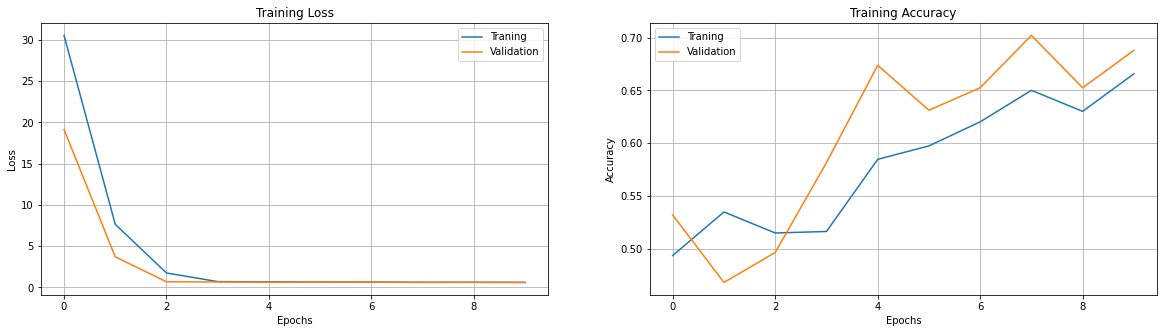

In [53]:
# Plot Training Loss
ig, ax = plt.subplots(1,2,figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(metrics_model_1.index, metrics_model_1['loss'], label='Traning')
plt.plot(metrics_model_1.index, metrics_model_1['val_loss'], label='Validation')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy Loss
plt.subplot(1,2,2)
plt.plot(metrics_model_1.index, metrics_model_1['accuracy'], label='Traning')
plt.plot(metrics_model_1.index, metrics_model_1['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [54]:
y_true = ds_val_pipe.classes

In [55]:
test_pred = model_1.predict(ds_val_pipe)

test_pred = test_pred > .5

print(classification_report(y_true, test_pred))

              precision    recall  f1-score   support

           0       0.61      0.89      0.73        66
           1       0.84      0.51      0.63        75

    accuracy                           0.69       141
   macro avg       0.73      0.70      0.68       141
weighted avg       0.74      0.69      0.68       141



> Second training sequential model with following architecture which consist four convolution layer filter which gradually increase from 64 to 256 neuron filters, resulting more than 14 billion params tobe executed, with 380 neurons fully connected layer.

In [66]:
model_2= Sequential()

#Conv 1, 
model_2.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape=(inputs_sz)))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
model_2.add(Conv2D(filters=90, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
model_2.add(Conv2D(filters=128, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 4
model_2.add(Conv2D(filters=256, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

model_2.add(Flatten())
model_2.add(Dense(units=380 , activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))

In [67]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 90)      51930     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 90)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 52, 52, 128)       103808    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 128)     

In [68]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [69]:
history_2 = model_2.fit(ds_train_pipe, batch_size= BATCH, 
                           epochs= 10, validation_data= ds_val_pipe,
                           callbacks= callbacks1)

Epoch 1/10
6/6 [==============================] - 88s 14s/step - loss: 1.0188 - accuracy: 0.5391 - val_loss: 0.6927 - val_accuracy: 0.4681
Epoch 2/10
6/6 [==============================] - 97s 18s/step - loss: 0.6956 - accuracy: 0.5135 - val_loss: 0.6980 - val_accuracy: 0.5319
Epoch 3/10
6/6 [==============================] - 124s 21s/step - loss: 0.6944 - accuracy: 0.4808 - val_loss: 0.6898 - val_accuracy: 0.6525
Epoch 4/10
6/6 [==============================] - 92s 13s/step - loss: 0.6900 - accuracy: 0.5349 - val_loss: 0.6798 - val_accuracy: 0.6099
Epoch 5/10
6/6 [==============================] - 107s 18s/step - loss: 0.6783 - accuracy: 0.5718 - val_loss: 0.6522 - val_accuracy: 0.6667
Epoch 6/10
6/6 [==============================] - 104s 15s/step - loss: 0.6614 - accuracy: 0.6287 - val_loss: 0.6370 - val_accuracy: 0.5957
Epoch 7/10
6/6 [==============================] - 91s 14s/step - loss: 0.6579 - accuracy: 0.6031 - val_loss: 0.6021 - val_accuracy: 0.6241
Epoch 8/10
6/6 [========

In [70]:
metrics_model_2 = pd.DataFrame(history_2.history)
metrics_model_2.head()

,loss,accuracy,val_loss,val_accuracy
0,1.018754,0.539118,0.692662,0.468085
1,0.695603,0.513514,0.697963,0.531915
2,0.694393,0.480797,0.689794,0.652482
3,0.689962,0.534851,0.679793,0.609929
4,0.678266,0.571835,0.652209,0.666667


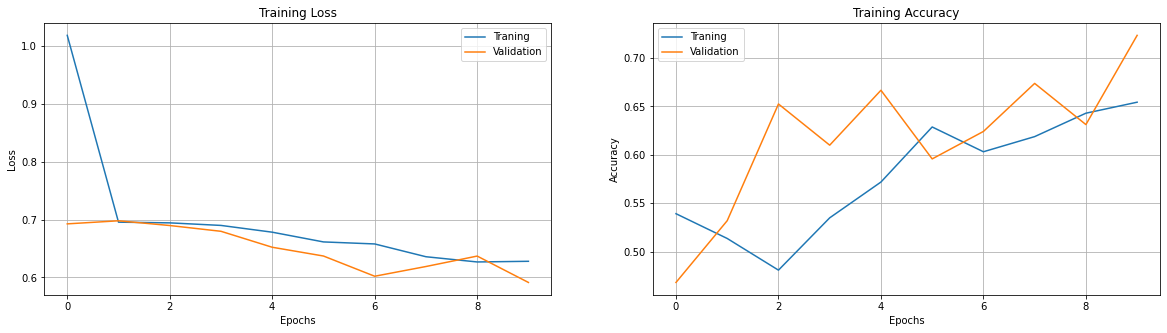

In [71]:
# Plot Training Loss
ig, ax = plt.subplots(1,2,figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(metrics_model_2.index, metrics_model_2['loss'], label='Traning')
plt.plot(metrics_model_2.index, metrics_model_2['val_loss'], label='Validation')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy Loss
plt.subplot(1,2,2)
plt.plot(metrics_model_2.index, metrics_model_2['accuracy'], label='Traning')
plt.plot(metrics_model_2.index, metrics_model_2['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [72]:
test_pred = model_2.predict(ds_val_pipe)

test_pred = test_pred > .5

print(classification_report(y_true, test_pred))

              precision    recall  f1-score   support

           0       0.64      0.94      0.76        66
           1       0.91      0.53      0.67        75

    accuracy                           0.72       141
   macro avg       0.77      0.74      0.72       141
weighted avg       0.78      0.72      0.71       141



# viii. Model Evaluation

> First training / model 1 evaluation.

Sequential model 1 with its architecture is resulting 69% accuracy, and the model was seemed good fit with the stable and converged training loss for both train and val set. Accuracy wise, train and val also seemed to be good fit despite a bit fluctuate on val side.
recall metric for class 1 is also still resulting around 51% which is not a good number to accept.

Due to this model is not good enough as the problem we want to solve is related to the safety, i deceided to run second model and the analysis is as follows:

> Second training / model 2 evaluation.

Sequentian model 2 with its architecture that is adding more convolution layer is actually resulting better accuracy with 72%.
Model 2 is also still showing small accuracy to predict on class 1, despite little increase compared to model 1.

Graphic wise, both loss and accuracy seemed still acceptable despite little fluctuative on accuracy performance. But then again, we are dealing with people's safety as the most important factor, so we need to improve the model to be able to predict the safety of the car.

i think we might using pretrained model which is already trained and well known that probably will resulting far better accuracy and performance.

# viii.i. Model Improvement

The model being tested on model improvement is Xception pretrained model combined with the sequential model. with simple infrastructure with only one layer that is pretrained model as the convolution, and one fully connected layer.

In [73]:
pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', \
                                                  input_shape=(224,224,3), pooling='avg')
pretrained_model.trainable = False

In [74]:
model_pr = Sequential()
model_pr.add(pretrained_model)
model_pr.add(Flatten())
model_pr.add(Dense(128, activation='relu'))
model_pr.add(Dense(1, activation='sigmoid'))

In [75]:
model_pr.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
_________________________________________________________________


In [76]:
model_pr.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [77]:
history_pr = model_pr.fit(ds_train_pipe, batch_size= BATCH, 
                           epochs= 17, validation_data= ds_val_pipe,
                           callbacks= callbacks1)

Epoch 1/17
6/6 [==============================] - 74s 12s/step - loss: 0.4519 - accuracy: 0.7994 - val_loss: 0.2971 - val_accuracy: 0.8794
Epoch 2/17
6/6 [==============================] - 66s 11s/step - loss: 0.2591 - accuracy: 0.9047 - val_loss: 0.1840 - val_accuracy: 0.9291
Epoch 3/17
6/6 [==============================] - 72s 12s/step - loss: 0.2365 - accuracy: 0.9161 - val_loss: 0.1769 - val_accuracy: 0.9220
Epoch 4/17
6/6 [==============================] - 67s 12s/step - loss: 0.2132 - accuracy: 0.9189 - val_loss: 0.1737 - val_accuracy: 0.9220
Epoch 5/17
6/6 [==============================] - 62s 10s/step - loss: 0.2183 - accuracy: 0.9232 - val_loss: 0.1654 - val_accuracy: 0.9220
Epoch 6/17
6/6 [==============================] - 63s 12s/step - loss: 0.1907 - accuracy: 0.9246 - val_loss: 0.2079 - val_accuracy: 0.9007
Epoch 7/17
6/6 [==============================] - 61s 10s/step - loss: 0.1877 - accuracy: 0.9417 - val_loss: 0.1355 - val_accuracy: 0.9362
Epoch 8/17
6/6 [===========

In [79]:
metrics_model_pr = pd.DataFrame(history_pr.history)
metrics_model_pr.head()

,loss,accuracy,val_loss,val_accuracy
0,0.451857,0.799431,0.297053,0.879433
1,0.259117,0.904694,0.184001,0.929078
2,0.236452,0.916074,0.176852,0.921986
3,0.213173,0.918919,0.173717,0.921986
4,0.218279,0.923186,0.165389,0.921986


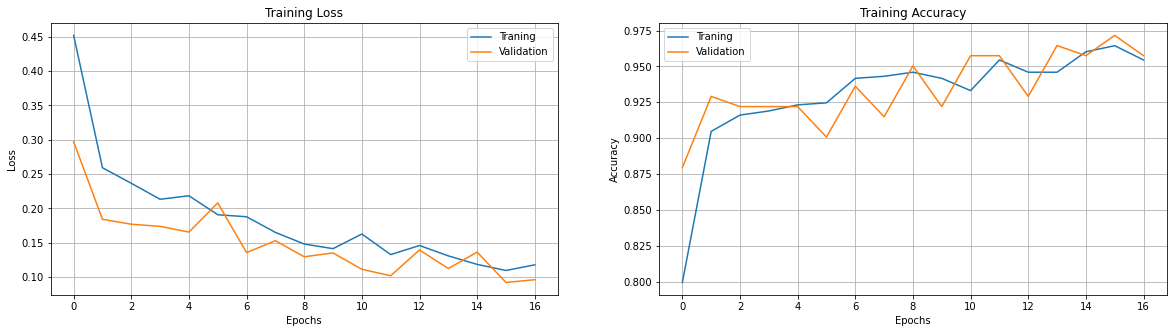

In [80]:
# Plot Training Loss
ig, ax = plt.subplots(1,2,figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(metrics_model_pr.index, metrics_model_pr['loss'], label='Traning')
plt.plot(metrics_model_pr.index, metrics_model_pr['val_loss'], label='Validation')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy Loss
plt.subplot(1,2,2)
plt.plot(metrics_model_pr.index, metrics_model_pr['accuracy'], label='Traning')
plt.plot(metrics_model_pr.index, metrics_model_pr['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [78]:
test_pred = model_pr.predict(ds_val_pipe)

test_pred = test_pred > .5

print(classification_report(y_true, test_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        66
           1       0.94      0.99      0.96        75

    accuracy                           0.96       141
   macro avg       0.96      0.96      0.96       141
weighted avg       0.96      0.96      0.96       141



> Confusion matrix

For further checking and to ensure, according to confusion matrix below showing that the majority of the wrong prediction is on false positive as the model predicted 5 normal tire while actually it supposed to be cracked.

In [107]:
THRESHOLD = 0.5
y_pred_class = (test_pred >= THRESHOLD).reshape(-1,)
y_true = ds_val_pipe.classes

pd.DataFrame(
    confusion_matrix(y_true, y_pred_class),
    index = [["Actual", "Actual"], ["cracked", "normal"]],
    columns = [["Predicted", "Predicted"], ["cracked", "normal"]])

Predicted       
                 cracked normal
Actual cracked        61      5
       normal          1     74

# viii.ii. Model Improvement Evaluation

> Finally! after using Xception pretrained model, i think we have the best model with the best accuracy and performance.

It is resulting 96% of accuracy, and the comparation between val and train showing on the graph also still acceptable despite a bit fluctuate on val side.

the model also seemed to be able to predict the two classes very well, as they are resulting more than 90% of accuracy on both classes.

# ix. Model Saving

> Saving model for deployment purposes.

In [87]:
model_pr.save('model_pr.h5')

# x. Model Inference

Load model for inference prediction.

In [102]:
model_inf = tf.keras.models.load_model('model_pr.h5')

Create function to load image

In [103]:
def load_img(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3) 
  img = resize(img, size=[img_shape, img_shape]) 
  img = img/255. # Rescale to 0-1
  return img

upload several images as inference to be predicted.

In [104]:
inf1 = load_img('Cracked-7.jpg')
inf2 = load_img('Cracked-9.jpg')
inf3 = load_img('IMG_4260.jpg')
inf4 = load_img('IMG_4295.jpg')

inference prediction and resulting correct prediction for each image.

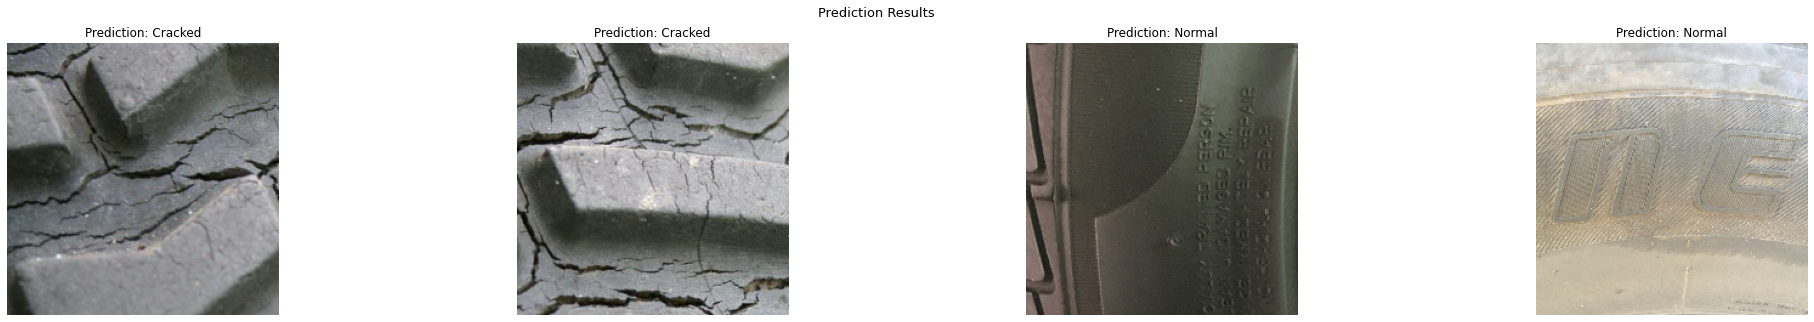

In [105]:
plt.figure(figsize=(35, 5))
plt.suptitle('Prediction Results', fontsize=13)
counter = 1
for i in [inf1, inf2, inf3, inf4,]:
    plt.subplot(1, 4, counter)
    res = int(tf.round(model_inf.predict(x=expand_dims(i, axis=0))))
    plt.imshow(i)
    plt.title(f"Prediction: {'Cracked' if res == 0 else 'Normal'}")
    plt.axis('off')
    counter += 1
plt.show()

# Conclusion

1. In this notebook, i have tried to create a model for tire texture classification, initially using sequential, and i have also tried to improve the model with Xception pretrained model as the convolution layer.

2. Best model is consist of 21 mio params, and the accuracy is 96% with the comparation between val and train showing on the graph also still acceptable despite a bit fluctuate on val side.

3. Preprocessing on data train is involving rescaling, rotation, shifting range, horizontal flip and zooming.

4. For further development, i need to improve the model to reduce the false negative in order to minimize the risk of accident.